In [11]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy.random as rd
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pandas as pd
import seaborn as sns
import random


from gene_tr import Calcphases,array,GenerateTraj,GeneratePhasesfromtrajectories
from ML_estimator import ML
from Evaluation import *
from KF import *
from Basic import *
from EKF import *

In [12]:
# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'ML parameters: f:{f},lmb:{lmb}')
#array
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location

filepath = 'C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_11'
figsize = (12,9)

ML parameters: f:860000000.0,lmb:0.3488372093023256


In [13]:

#generate N_tr trajectories and store the data

N_tr=50 #number of trajectories
Length=100 #length of a trajectory
dt=0.1

#trajectory parameters-1d
F_1 = np.array([[1, dt], [0, 1]])
H_1=np.array([1,0])  
q=0.001
Q_1 =  (q**2)*np.array([[(dt**3)/3,(dt**2)/2],[(dt**2)/2,dt]]) 
r=1
R_1 = r**2  # position observation noise

# #trajectory parameters-2d
zero_2_2=np.zeros([2,2])
zero_1_2=np.zeros([1,2])
F = np.block([[F_1,zero_2_2],[zero_2_2,F_1]])
H = np.block([[H_1,zero_1_2],[zero_1_2,H_1]])
Q = np.block([[Q_1,zero_2_2],[zero_2_2,Q_1]])
R = np.block([[R_1,0],[0,R_1]])

#Generate 50 trajectories and save them in a txt file
real_states=np.zeros((N_tr,Length,4))

for i in range (N_tr):
    #Initial position
    x_start = np.random.uniform(3,5,1).squeeze()
    y_start = np.random.uniform(4,6,1).squeeze()
    X0 = np.array([0,x_start,1,y_start]).reshape(4,1)  #初始位置最好不要和q0重合
    r_s = GenerateTraj(Length,X0,F,Q)
    real_states[i,:,:] = r_s.reshape(Length,4)

with open('trajectories_states.txt', 'w') as outfile:
    for slice_2d in real_states:
        np.savetxt(outfile, slice_2d, fmt = '%f', delimiter = ',')


real_states= np.loadtxt('trajectories_states.txt', delimiter = ',').reshape((N_tr, Length, 4))

In [14]:
def Estimate_MLencoder_MSE(Length, states_train, Phases_train, H, F, prior_std, arr, lmb, ml_resol,searchfactor):
    
    num_train=states_train.shape[0]
    ML_output=np.empty([num_train,Length,2])
    for i in range(num_train):
       
        Phases_i = Phases_train[i,:,:] # Phases of the i-th trajectory, size: Length*N
        
        for j in range(Length):
            #synthetic prior
            if(j==0):
                prior_mean=np.array([states_train[i,0,0],states_train[i,0,2]]) #[x0[0],x0[2]]
            else:
                prior_mean=H@(F@states_train[i,j-1,:]) #Fx_t-1[0],Fx_t-1[2]
            #search space
            xrange_p=np.array([prior_mean[0]-searchfactor*prior_std,prior_mean[0]+searchfactor*prior_std])
            yrange_p=np.array([prior_mean[1]-searchfactor*prior_std,prior_mean[1]+searchfactor*prior_std])
            
            y_k=Phases_i[j,:]
            ml=ML()
            _,Loc_MLgrid=ml.ML_grid(xrange_p,yrange_p,y_k,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            ML_output[i,j]=Loc_MLgrid.reshape(2) 
    #compute MSE for x position and y position
    ML_output_x=ML_output[:,:,0].reshape([num_train,Length,1])
    ML_output_y=ML_output[:,:,1].reshape([num_train,Length,1])
    states_train_x=states_train[:,:,0].reshape([num_train,Length,1])
    states_train_y=states_train[:,:,2].reshape([num_train,Length,1])


    MSE_x_mean,MSE_x_std=evaluate(states_train_x,ML_output_x)
    MSE_y_mean,MSE_y_std=evaluate(states_train_y,ML_output_y)
    # print(f'MSE_x_mean:{MSE_x_mean},MSE_x_std:{MSE_x_std}')
    # print(f'MSE_y_mean:{MSE_y_mean},MSE_y_std:{MSE_y_std}')

    R_ML=np.array([[MSE_x_mean,0],[0,MSE_y_mean]])
    print(f'R_ML:{R_ML}')
    return R_ML

# 测试一下没有噪声的时候的KF+ML

In [15]:
def plot_example_Exp1_testKF_ML(real_states,z_i,filter_result,dt,flag_save):
    
    plt.figure(figsize=figsize)
    plt.subplot(221)
    # plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,0], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.plot(np.arange(1*dt,len(z_i)*dt,dt), z_i[1:,0], label = 'z_i',c='r',linestyle='--',linewidth=1)


    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'/Tracking_Exp1_Result_px.png')
    # plt.savefig(filepath+'/Tracking_Exp1_Result_px.eps',format='eps') 

    # plt.figure(figsize=figsize)
    plt.subplot(222)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,1], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,1], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)


    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('x-velocity [m/s]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'Tracking_Exp1_Result_vx.png')
    # plt.savefig(filepath+'/Tracking_Exp1_Result_vx.eps',format='eps') 

    # plt.figure(figsize=figsize)
    plt.subplot(223)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,2], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,2], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.plot(np.arange(1*dt,len(z_i)*dt,dt), z_i[1:,1], label = 'z_i',c='r',linestyle='--',linewidth=1)

    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'/Tracking_Exp1_Result_py.png')
    # plt.savefig(filepath+'/Tracking_Exp1_Result_py.eps',format='eps') 

    # plt.figure(figsize=figsize)
    plt.subplot(224)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,3], label = 'Ground truth',c='g',linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,3], label = 'KF + ML encoder',c='b',linestyle='--',linewidth=1)
  

    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('y-velocity [m/s]',fontsize=14)
    plt.legend()
    # plt.savefig(filepath+'racking_Exp1_Result_vy.png')
    # plt.savefig(filepath+'Tracking_Exp1_Result_vy.eps',format='eps') 



In [16]:
def Exp1_testKF_ML(num_test,states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test,Phase_noise_std,search_factor,flagplot):
    EF_ML_output=np.empty([num_test,Length,4])

    for i in range(num_test):
        
        #generate phases
        real_states_i=states_test[i,:,:].reshape(Length,4,1)
        Phases_i = Phases_test[i,:,:]
        
        #EXP1-1:EF+ML
        #init
        x0_KF = real_states_i[0,:,:].reshape(4,1)
        P0_KF=np.zeros([4,4])#initial state fully known

        z_i,filter_result_i = KF_ML(Length=Length,dt=dt,x0=x0_KF,P0=P0_KF,F=F,H=H,Q=Q,R=R_ML, #here! R should be replaced by the MSE of ML encoder
                                                    lmb=lmb,ml_resol=ml_resol,std=prior_std,arr=arr,Phases=Phases_i,search_factor=search_factor)
        

        EF_ML_output[i]=filter_result_i


        #plot one trajectory with large error on z estimation (ML output)
        # if(np.max(abs(z_i[:,0]-real_states_i[1:,0]))>5 and flagplot==True):
        if(i==0 and flagplot==True):
            plot_example_Exp1_testKF_ML(real_states_i,z_i,EF_ML_output[i],dt,flag_save=False)
    
    

    states_test_xy=np.stack([states_test[:,:,0],states_test[:,:,2]],axis=2)
    EF_ML_output_xy=np.stack([EF_ML_output[:,:,0],EF_ML_output[:,:,2]],axis=2)
    EF_ML_MSE_xy_mean,EF_ML_MSE_xy_std=evaluate(states_test_xy,EF_ML_output_xy)
    print(f'EF_ML_MSE_xy_mean:{EF_ML_MSE_xy_mean}')



    return EF_ML_MSE_xy_mean

In [17]:
# noise_dB=np.array([10,20,30,40,50,60])
Phase_noise_std= np.array([0.1,0.01,0.001,0]) #consider noise-free case
print(f'Phase_noise_sigma:{Phase_noise_std}')

# Generate phases
Phases=np.empty([len(Phase_noise_std),N_tr,Length,N])
phase_offset=0
for i in range(len(Phase_noise_std)):
    print(f'Phase_noise_std:{Phase_noise_std[i]}')
    Phases[i] = GeneratePhasesfromtrajectories(N_tr,Length,arr,lmb,phase_offset,real_states,Phase_noise_std[i])

#split the data into training set and test set
num_train=int(0.3*N_tr);num_test=N_tr-num_train
Phases_train= Phases[:,0:num_train,:,:]; Phases_test=Phases[:,num_train:,:,:]
states_train = real_states[0:num_train,:,:]; states_test= real_states[num_train:,:,:]


Phase_noise_sigma:[0.1   0.01  0.001 0.   ]
Phase_noise_std:0.1
Phase_noise_std:0.01
Phase_noise_std:0.001
Phase_noise_std:0.0


## Bad，prior_std large, ml_resol small

ml estimator searching std is 0.5 wavelength，0.1744186046511628[m]
ml estimator searching resolution is 0.30000000000000004 wavelength,0.1046511627906977 [m]
Phase_noise_std:0.1
R_ML:[[0.0687631  0.        ]
 [0.         0.13459826]]
EF_ML_MSE_xy_mean:0.00010539658276403372
Phase_noise_std:0.01
R_ML:[[0.0571474 0.       ]
 [0.        0.0972823]]
EF_ML_MSE_xy_mean:0.00011467103366776512
Phase_noise_std:0.001
R_ML:[[0.01707762 0.        ]
 [0.         0.03181853]]
EF_ML_MSE_xy_mean:0.0004153774124222309
Phase_noise_std:0.0
R_ML:[[3.31204033e-10 0.00000000e+00]
 [0.00000000e+00 3.53470427e-10]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


EF_ML_MSE_xy_mean:24.45905626097359


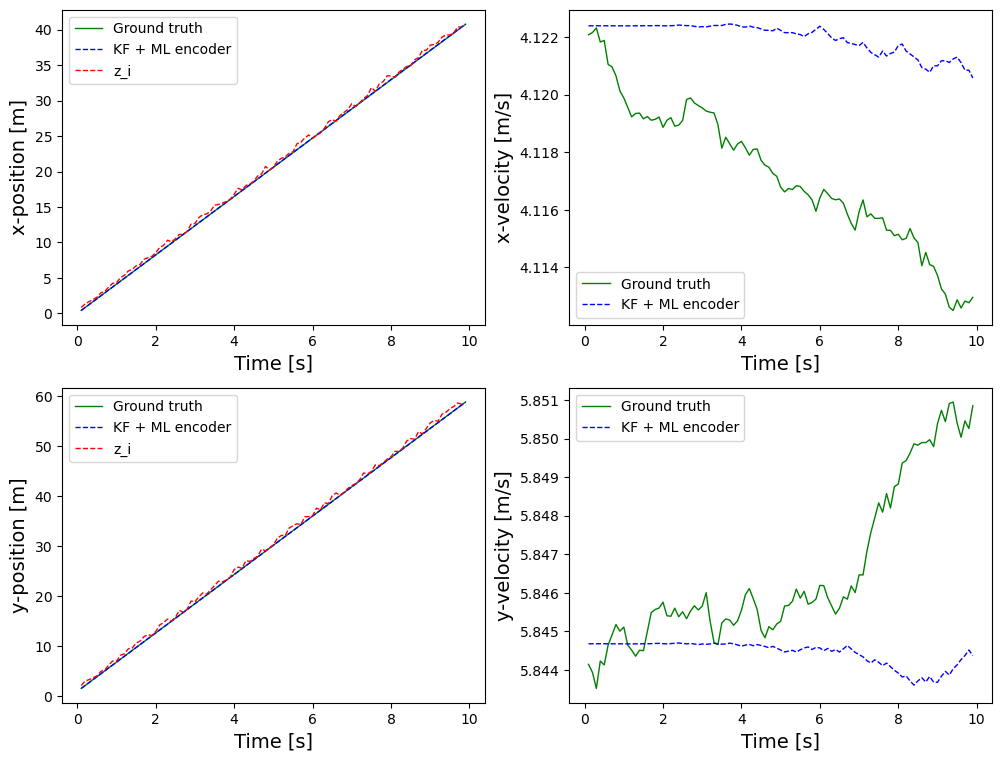

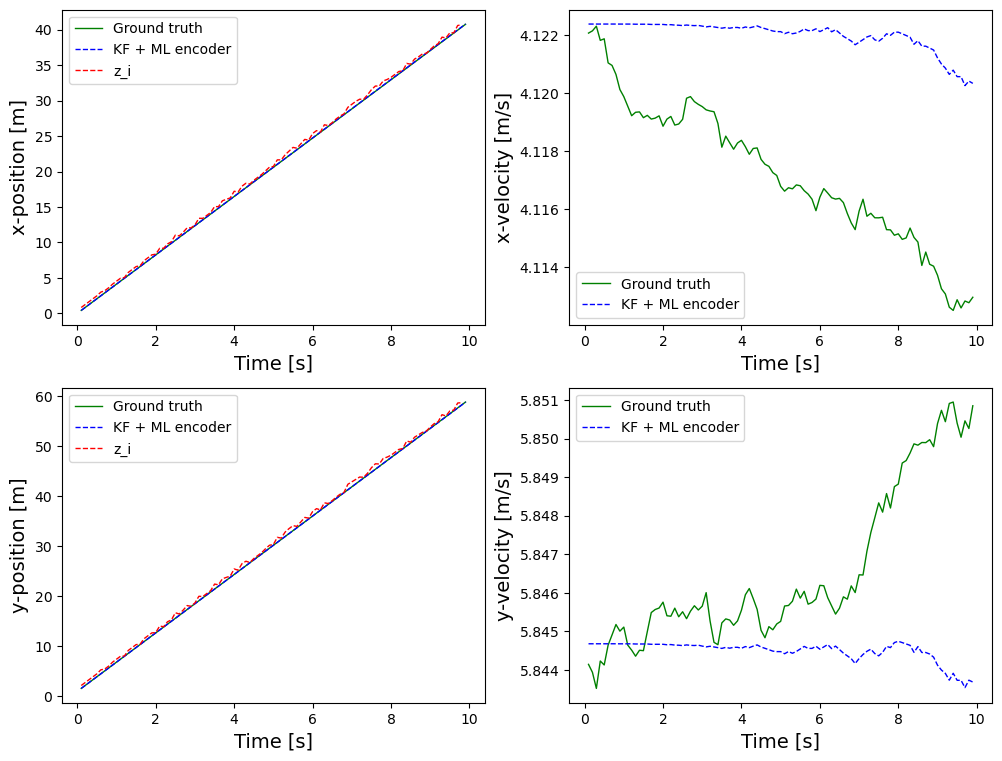

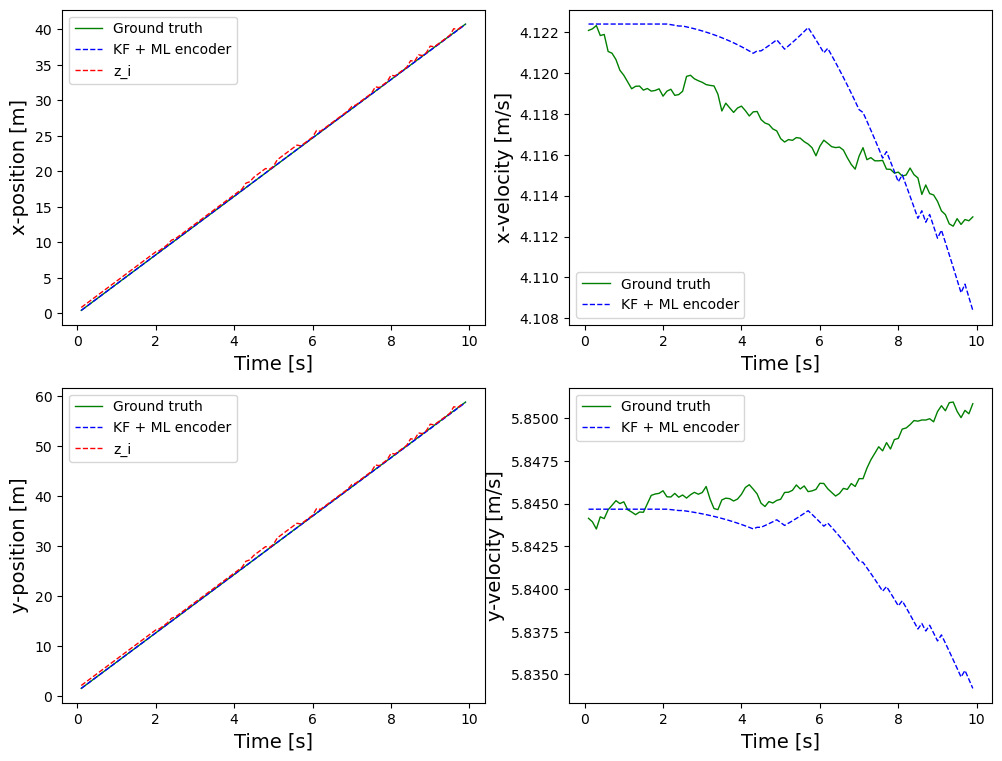

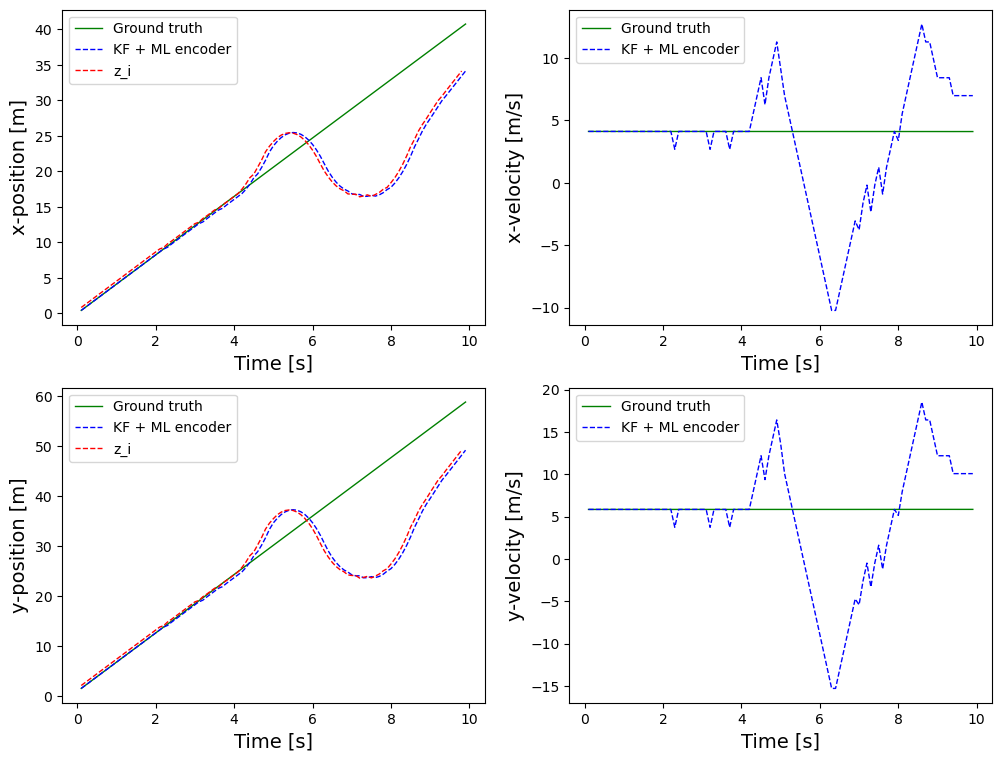

In [18]:
#参数设置
searchfactor=3#改小它和改小prior_std作用一样，因为在决定search space总是要乘上一个很searchfactor.重要的决定性因素2
prior_std=0.5*lmb
phase_offset=0
ml_resol=0.1*2*searchfactor*prior_std #小于0.2,就会出现很差的情况。重要的决定性因素1
print(f'ml estimator searching std is {prior_std/lmb} wavelength，{prior_std}[m]')
print(f'ml estimator searching resolution is {ml_resol/lmb} wavelength,{ml_resol} [m]')
EF_ML_MSE_xy_mean=np.empty(1)



for i in range(len(Phase_noise_std)):
    print(f'Phase_noise_std:{Phase_noise_std[i]}')

    R_ML=Estimate_MLencoder_MSE(Length,states_train,Phases_train[i],H,F,prior_std,arr,lmb,ml_resol,searchfactor)
    EF_ML_MSE_xy_mean= Exp1_testKF_ML(num_test,states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test[i],Phase_noise_std[i],searchfactor,flagplot=True)
plt.savefig(filepath+'/ML_encoder_output_1.eps',format='eps') 

## Better，prior_std large，ml_resol good. Still MSE increases as noise decreases

ml estimator searching std is 0.5 wavelength，0.1744186046511628[m]
ml estimator searching resolution is 0.9 wavelength,0.313953488372093 [m]
Phase_noise_std:0.1
R_ML:[[0.09144775 0.        ]
 [0.         0.12228882]]
EF_ML_MSE_xy_mean:0.00011486912341666526
Phase_noise_std:0.01
R_ML:[[0.05048829 0.        ]
 [0.         0.07191028]]
EF_ML_MSE_xy_mean:0.00010142875083725675
Phase_noise_std:0.001
R_ML:[[0.01614315 0.        ]
 [0.         0.03585636]]
EF_ML_MSE_xy_mean:0.00032943582266149496
Phase_noise_std:0.0
R_ML:[[0.01303269 0.        ]
 [0.         0.03274605]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


EF_ML_MSE_xy_mean:0.0003281886394904589


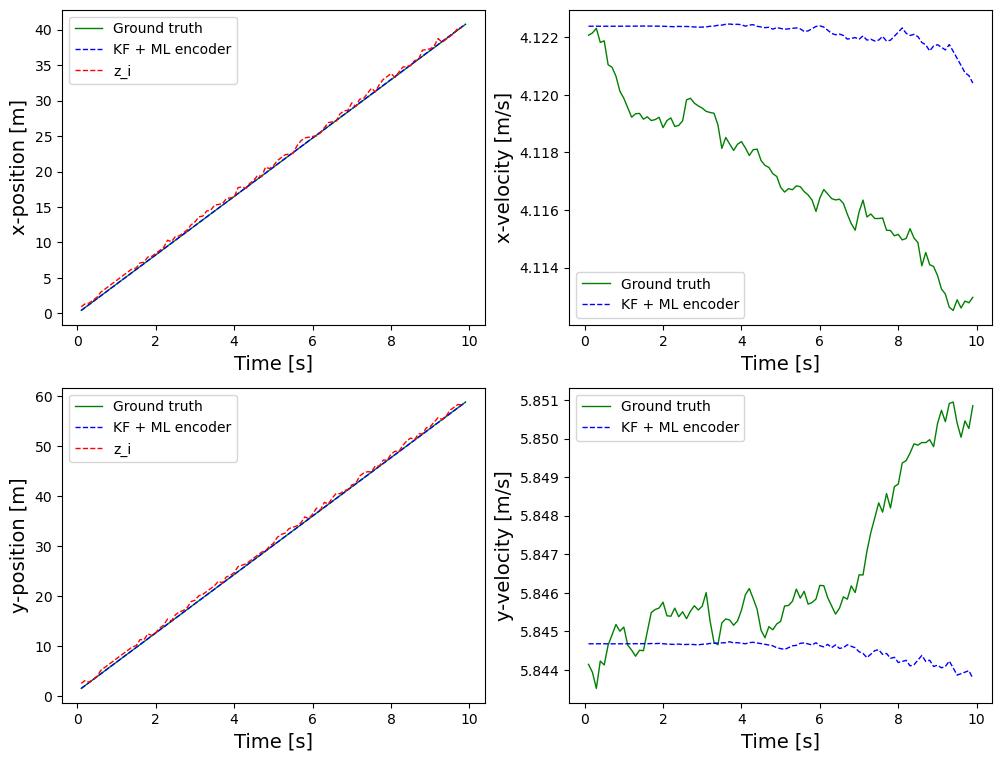

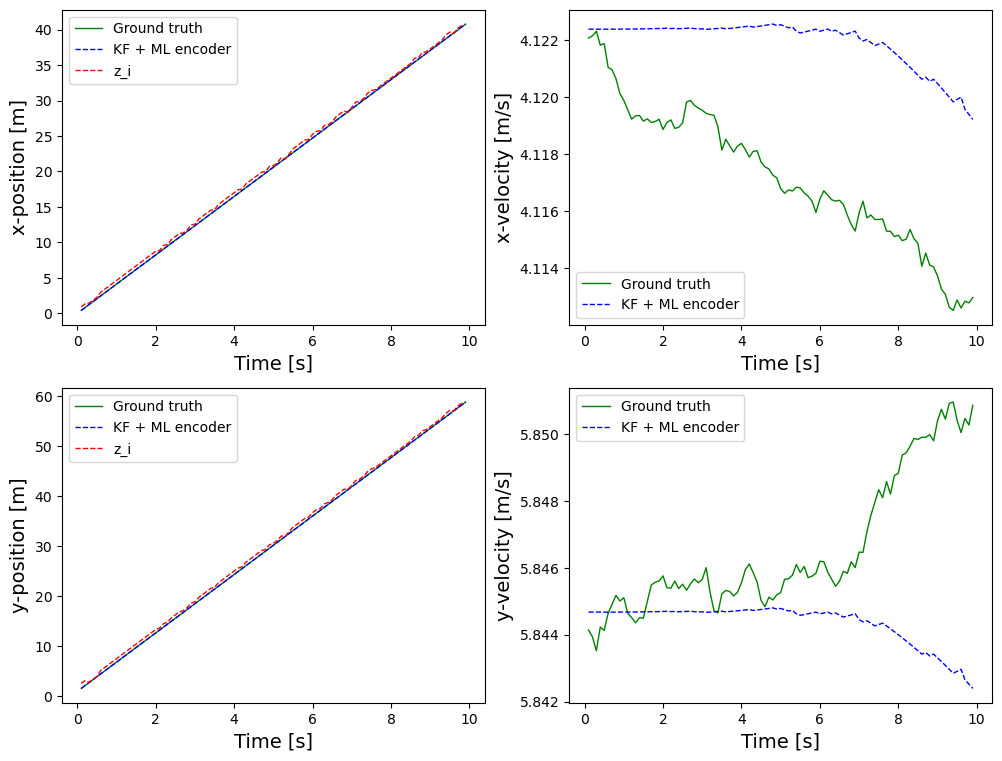

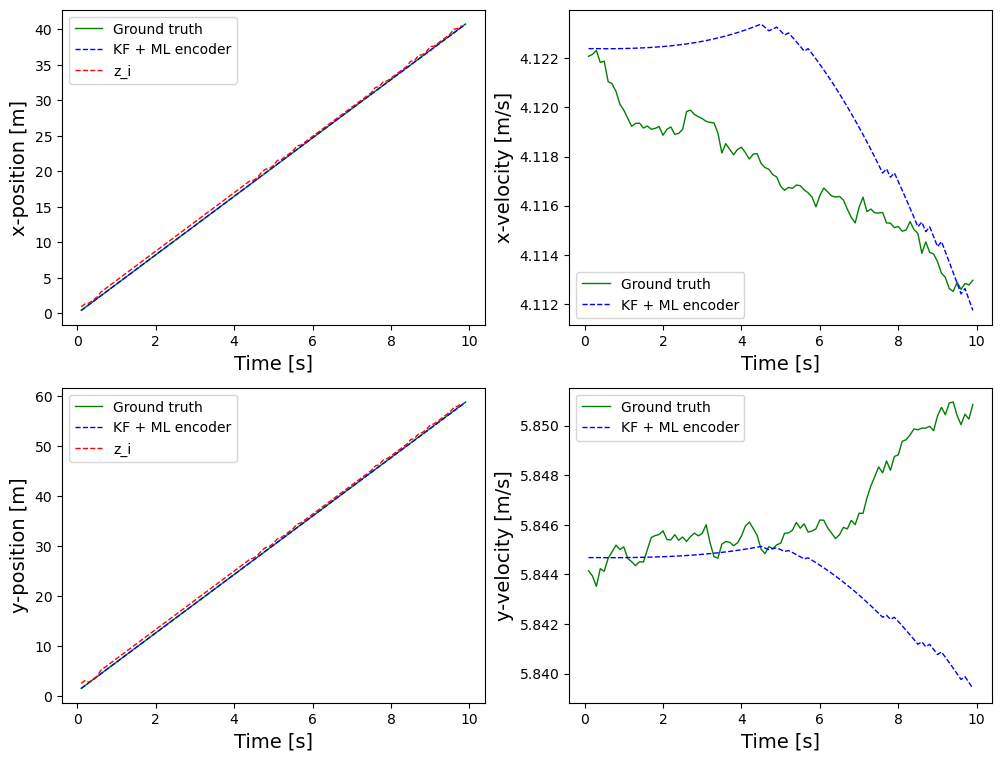

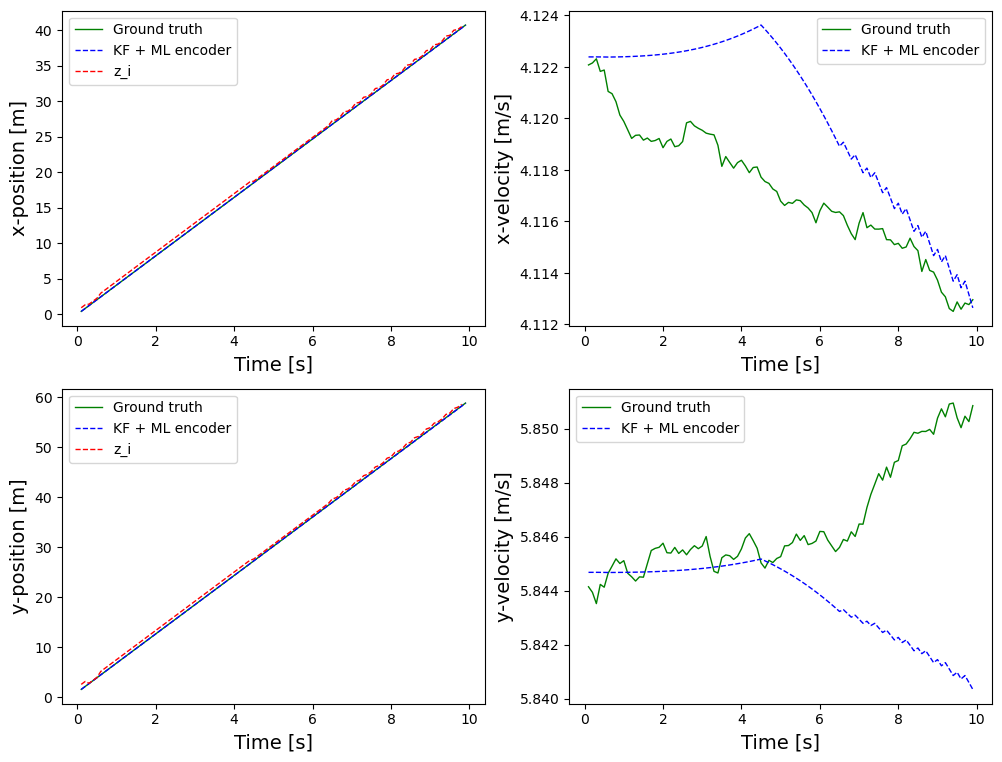

In [19]:
#参数设置
searchfactor=3#改小它和改小prior_std作用一样，因为在决定search space总是要乘上一个很searchfactor.重要的决定性因素2
prior_std=0.5*lmb
phase_offset=0
ml_resol=0.3*2*searchfactor*prior_std #小于0.2,就会出现很差的情况。重要的决定性因素1
print(f'ml estimator searching std is {prior_std/lmb} wavelength，{prior_std}[m]')
print(f'ml estimator searching resolution is {ml_resol/lmb} wavelength,{ml_resol} [m]')
EF_ML_MSE_xy_mean=np.empty(1)



for i in range(len(Phase_noise_std)):
    print(f'Phase_noise_std:{Phase_noise_std[i]}')

    R_ML=Estimate_MLencoder_MSE(Length,states_train,Phases_train[i],H,F,prior_std,arr,lmb,ml_resol,searchfactor)
    EF_ML_MSE_xy_mean= Exp1_testKF_ML(num_test,states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test[i],Phase_noise_std[i],searchfactor,flagplot=True)
plt.savefig(filepath+'/ML_encoder_output_2.eps',format='eps') 

## Good 

ml estimator searching std is 0.001 wavelength，0.0003488372093023256[m]
ml estimator searching resolution is 0.0017999999999999997 wavelength,0.000627906976744186 [m]
Phase_noise_std:0.1
R_ML:[[8.92297887e-07 0.00000000e+00]
 [0.00000000e+00 8.95696246e-07]]
EF_ML_MSE_xy_mean:0.00018819932181865173
Phase_noise_std:0.01
R_ML:[[8.61951226e-07 0.00000000e+00]
 [0.00000000e+00 8.53130204e-07]]
EF_ML_MSE_xy_mean:0.00011863828144015942
Phase_noise_std:0.001
R_ML:[[6.32377186e-07 0.00000000e+00]
 [0.00000000e+00 6.92085604e-07]]
EF_ML_MSE_xy_mean:0.00010997709400234692
Phase_noise_std:0.0
R_ML:[[1.11847111e-07 0.00000000e+00]
 [0.00000000e+00 1.99812054e-07]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


EF_ML_MSE_xy_mean:0.0006047724606013856


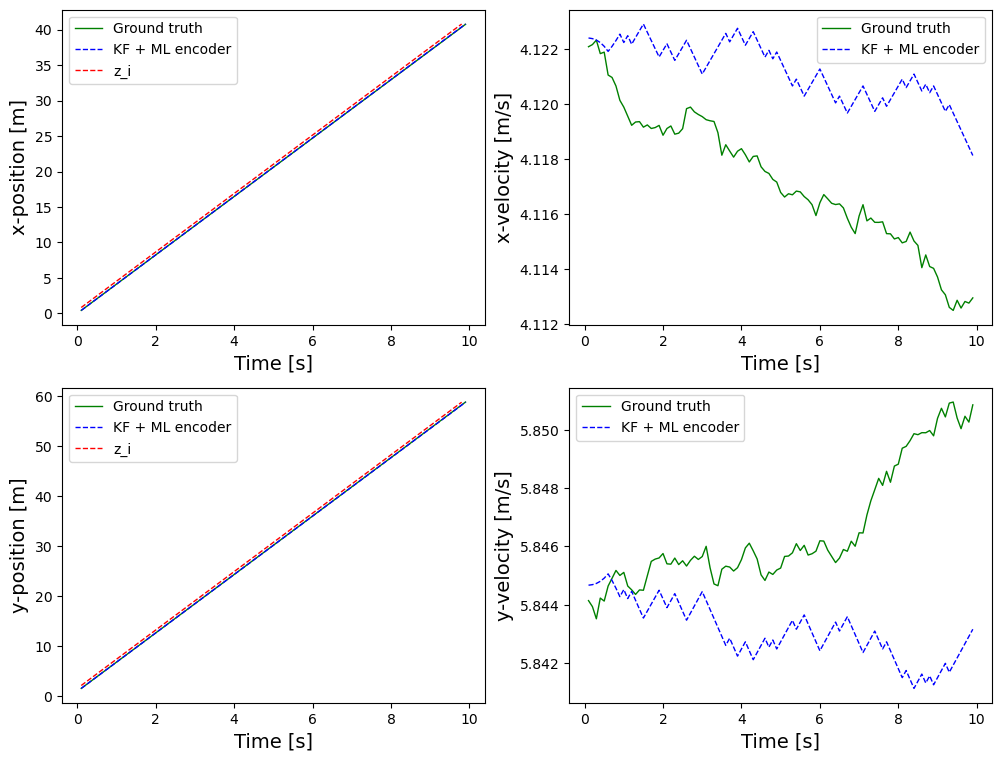

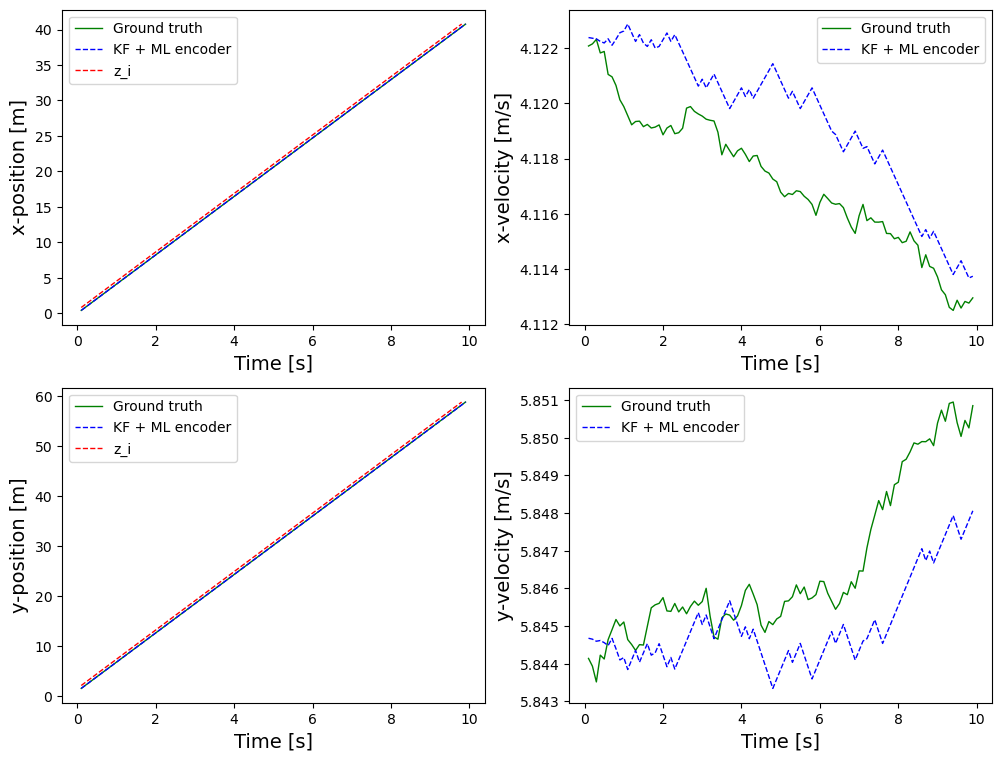

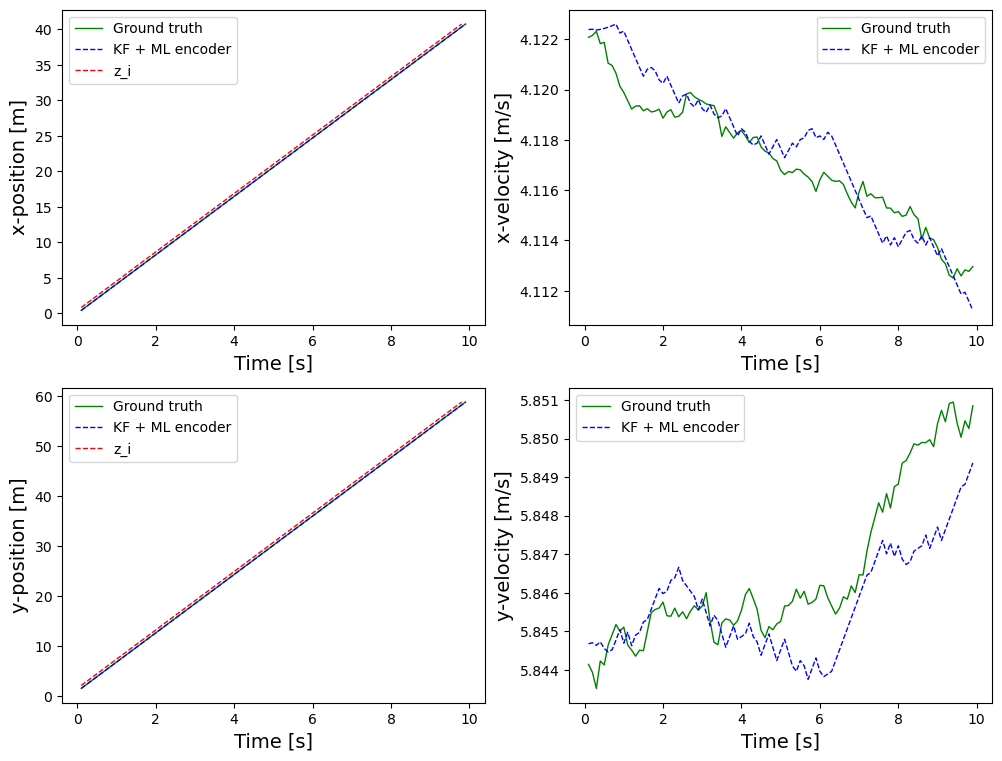

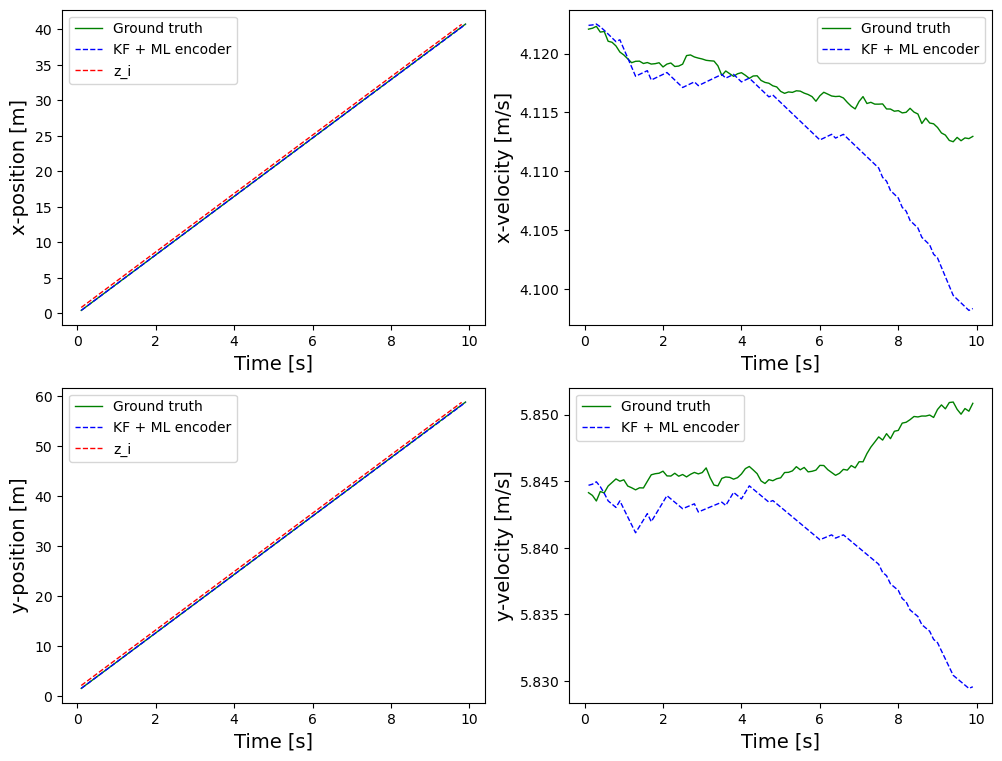

In [20]:
#参数设置
searchfactor=3#改小它和改小prior_std作用一样，因为在决定search space总是要乘上一个很searchfactor.重要的决定性因素2
prior_std=0.001*lmb
phase_offset=0
ml_resol=0.3*2*searchfactor*prior_std #小于0.2,就会出现很差的情况。重要的决定性因素1
print(f'ml estimator searching std is {prior_std/lmb} wavelength，{prior_std}[m]')
print(f'ml estimator searching resolution is {ml_resol/lmb} wavelength,{ml_resol} [m]')
EF_ML_MSE_xy_mean=np.empty(1)


for i in range(len(Phase_noise_std)):
    print(f'Phase_noise_std:{Phase_noise_std[i]}')
    
    R_ML=Estimate_MLencoder_MSE(Length,states_train,Phases_train[i],H,F,prior_std,arr,lmb,ml_resol,searchfactor)
    EF_ML_MSE_xy_mean= Exp1_testKF_ML(num_test,states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test[i],Phase_noise_std[i],searchfactor,flagplot=True)

plt.savefig(filepath+'/ML_encoder_output_3.eps',format='eps') 